In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
# paths
img_path = "/Users/tracysanchezpacheco/Library/CloudStorage/OneDrive-Personal/PhD/Creation/Paper_Figures/Raw_Material/Map_Black_White.jpg"
json_path = "/Volumes/TwoTeras/Graph_Stuff/Ressources/Avatar_Coordinates/AllAvatarsList_Coordinates_Exp1.json"

In [3]:
# load image
img = Image.open(img_path)

with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

rows = []

for avatar_key, avatar in data.items():
    avatar_id = avatar["AvatarID"]
    pos = avatar["AvatarPositionGlobal"]  # or AvatarPositionGlobal

    rows.append({
        "avatar_key": avatar_key,
        "avatar_id": avatar_id,
        "x": pos["x"],
        "y": pos["y"],   # height (keep or drop later)
        "z": pos["z"],
        "type": "contextual" if avatar_id <= 28 else "acontextual"
    })

df = pd.DataFrame(rows)

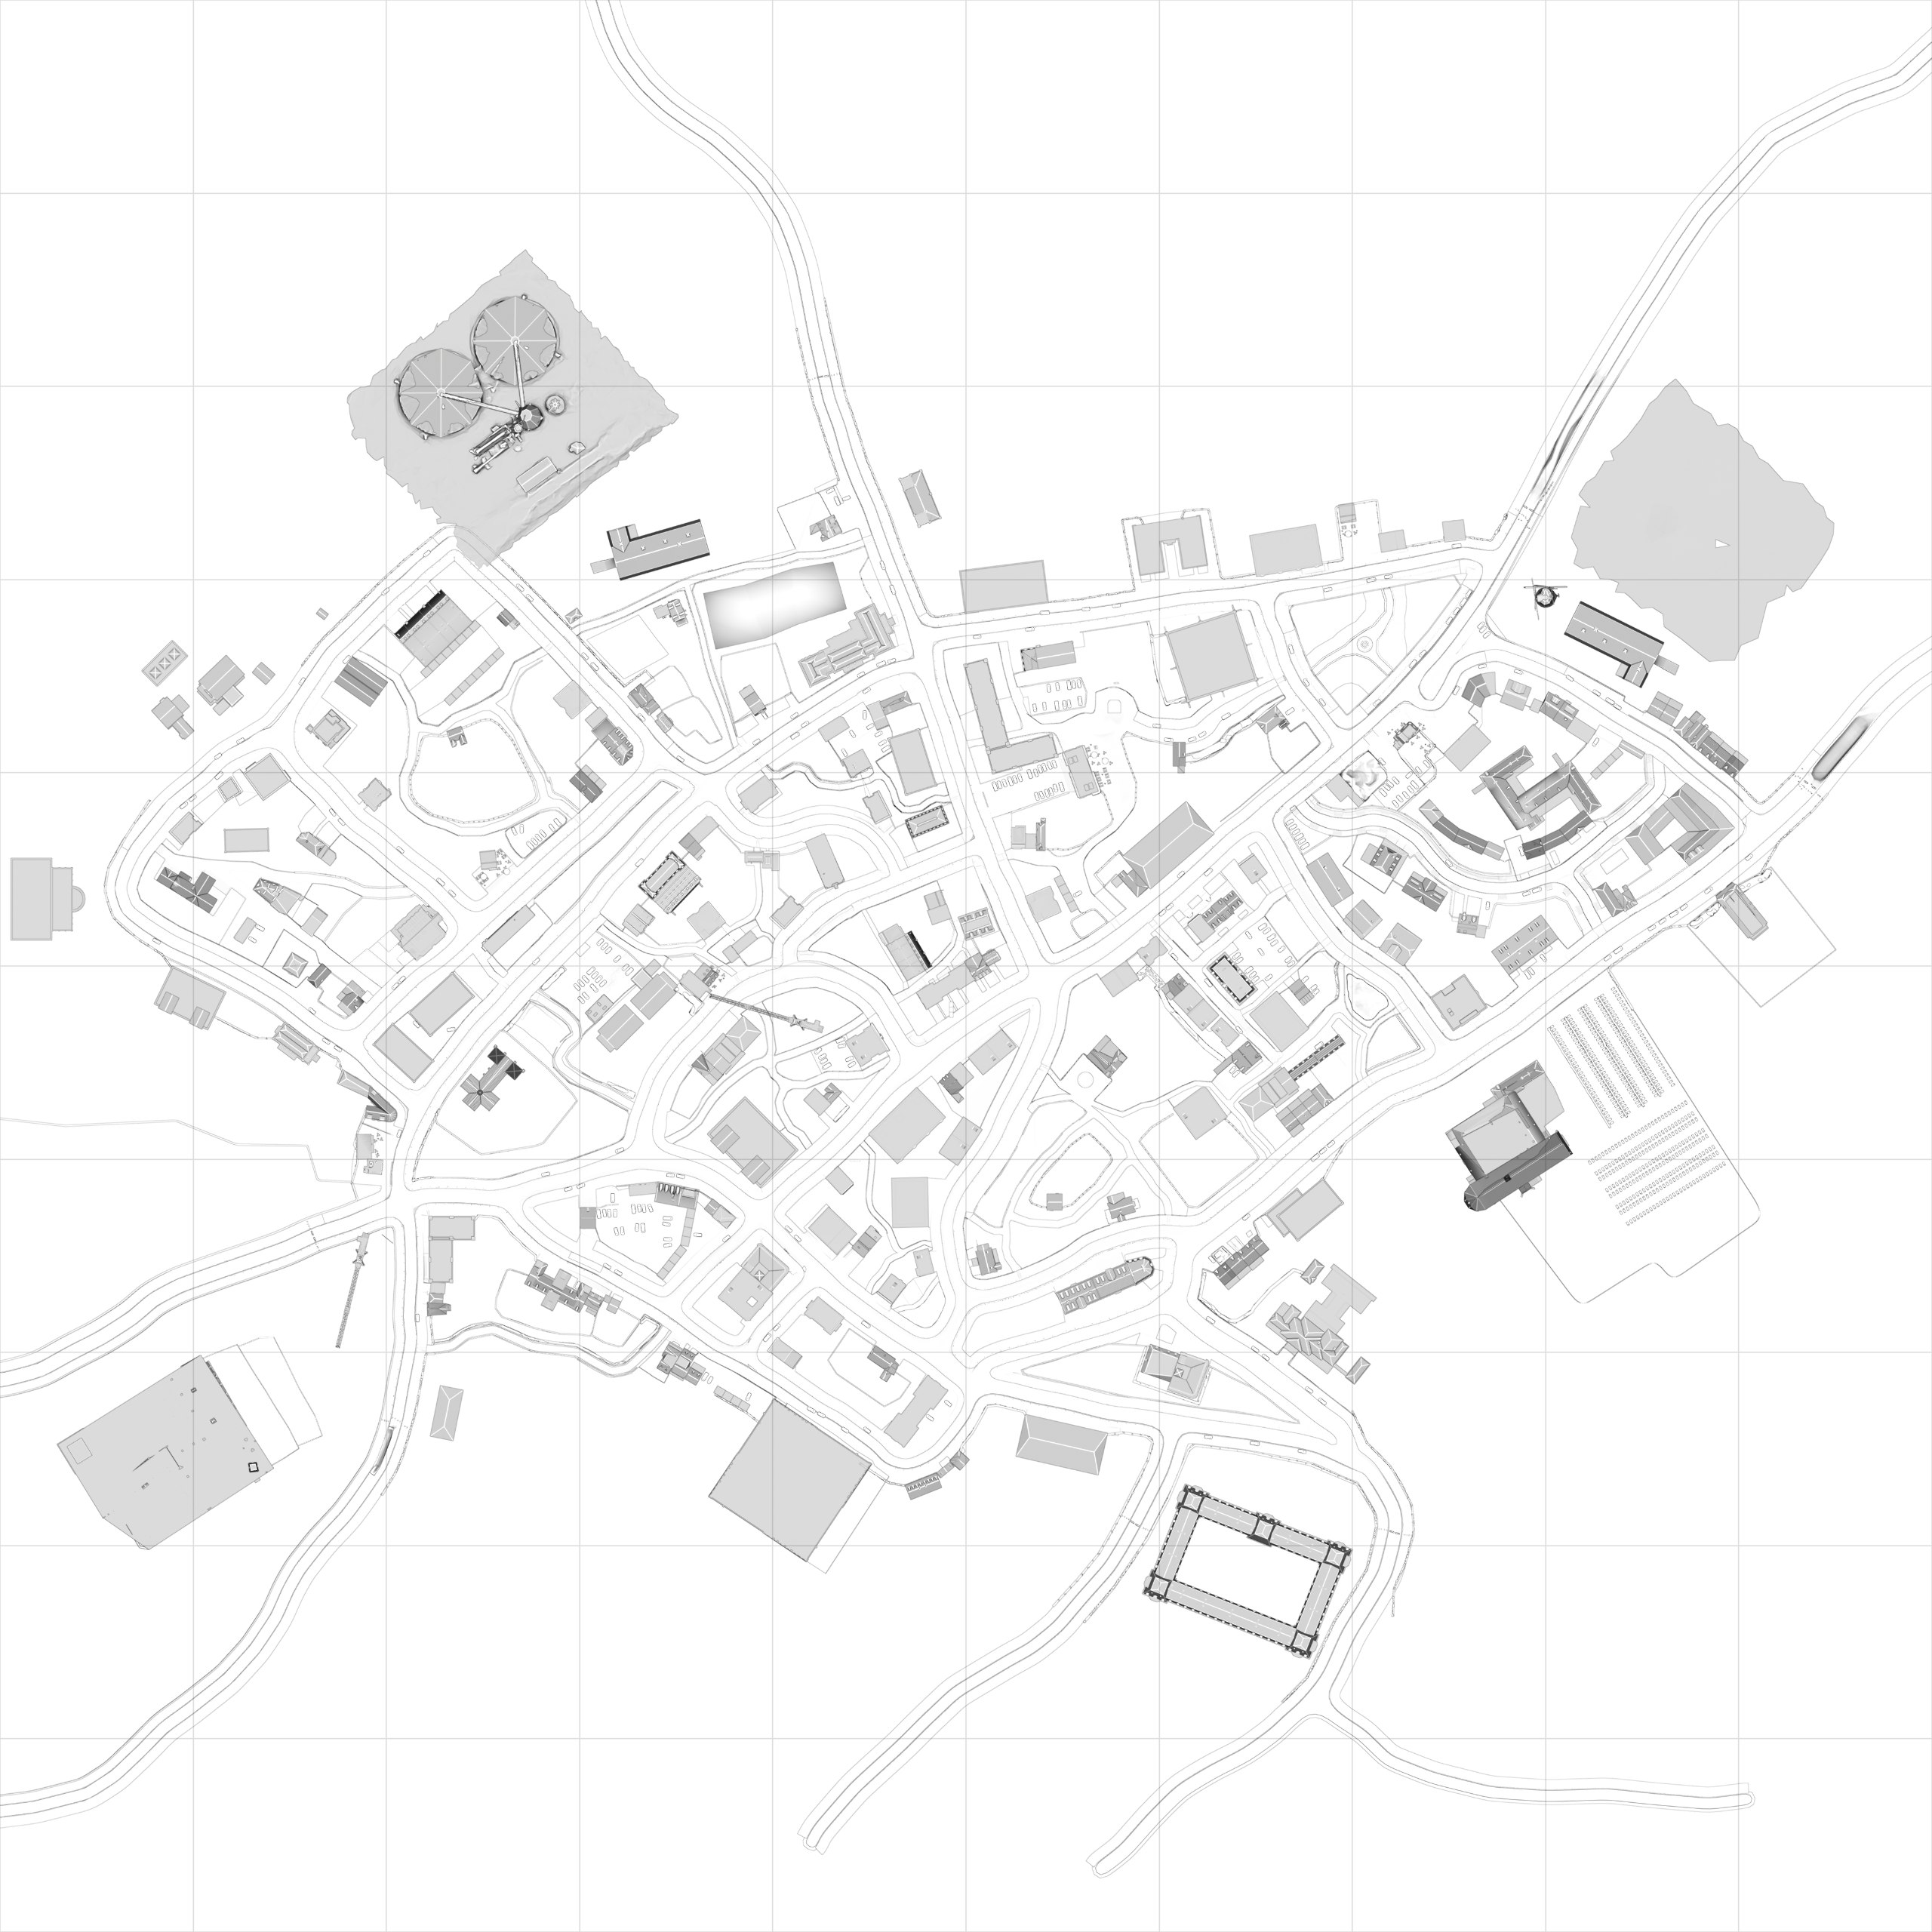

In [4]:
img

In [22]:
type_colors = {
    "acontextual": "#08306B",  # extreme blue
    "contextual":  "#67000D"   # extreme red
}
df["color"] = df["type"].map(type_colors)
df[["avatar_id", "type", "color"]].head()

type_colors_light = {
    "acontextual": "#9ECAE1",  # light blue
    "contextual":  "#FC9272"   # light red
}

df["color_light"] = df["type"].map(type_colors_light)



In [23]:
import matplotlib.pyplot as plt

# SAME bounds as your map
MAP_XMIN, MAP_XMAX = -450, 450
MAP_ZMIN, MAP_ZMAX = -300, 300

fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

# transparent background
fig.patch.set_alpha(0)
ax.set_facecolor((0, 0, 0, 0))

# larger points, no edge
ax.scatter(
    df["x"],
    df["z"],
    c=df["color_light"],
    s=120,          # <-- bigger points
    edgecolors="none",
    alpha=0.9
)

# framing must match the base map exactly
ax.set_xlim(MAP_XMIN, MAP_XMAX)
ax.set_ylim(MAP_ZMIN, MAP_ZMAX)   # flip to (MAP_ZMAX, MAP_ZMIN) if needed
ax.set_aspect("equal", adjustable="box")
ax.axis("off")

out_path = "/Volumes/TwoTeras/Graph_Stuff/Ressources/agents_overlay_light.png"
plt.savefig(out_path, transparent=True, pad_inches=0)
plt.close(fig)

print("Saved:", out_path)


Saved: /Volumes/TwoTeras/Graph_Stuff/Ressources/agents_overlay_light.png


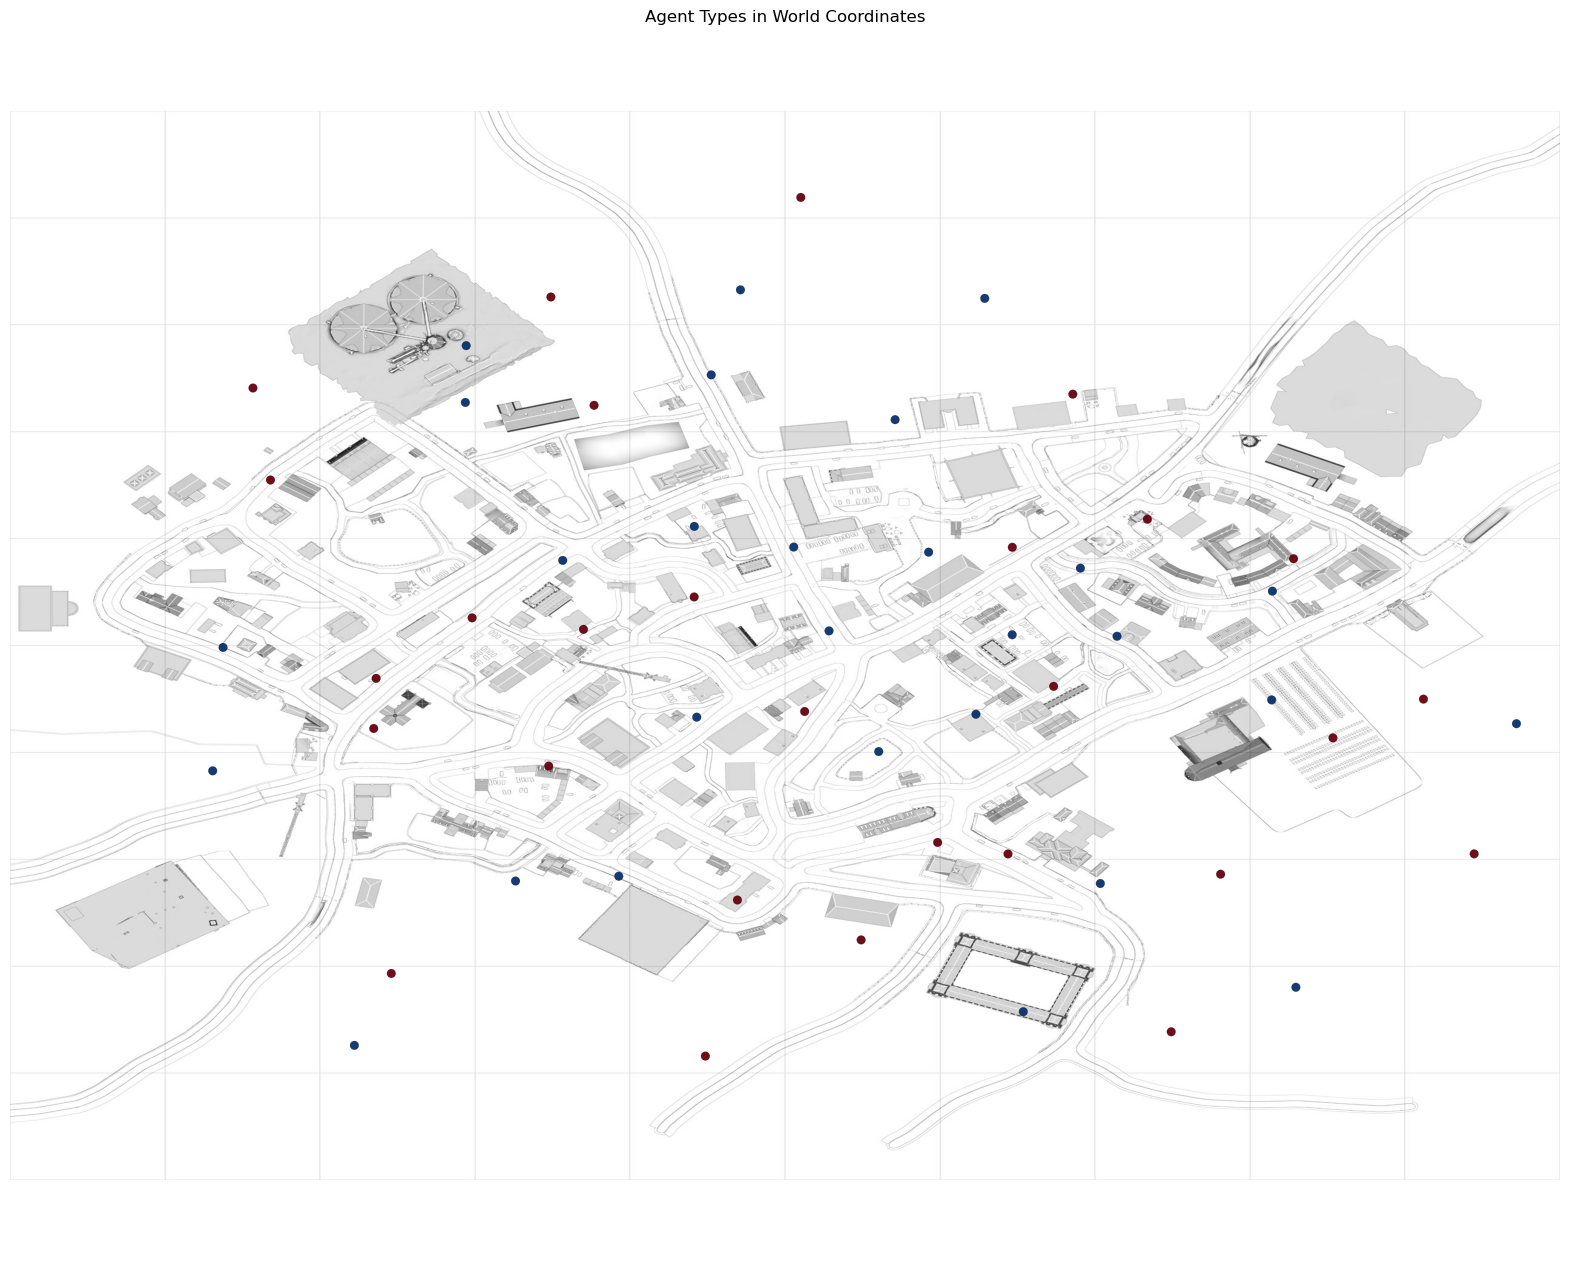

In [21]:
plt.figure(figsize=(20, 16))

plt.imshow(
    img,
    extent=[MAP_XMIN, MAP_XMAX, MAP_ZMAX, MAP_ZMIN]  # <-- z inverted here
)

plt.scatter(
    df["x"],        # world x
    df["z"],        # world z
    c=df["color"],
    s=40,
    edgecolor="black",
    linewidth=0.1,
    alpha=0.95
)

plt.axis("equal")
plt.axis("off")
plt.title("Agent Types in World Coordinates")

plt.show()

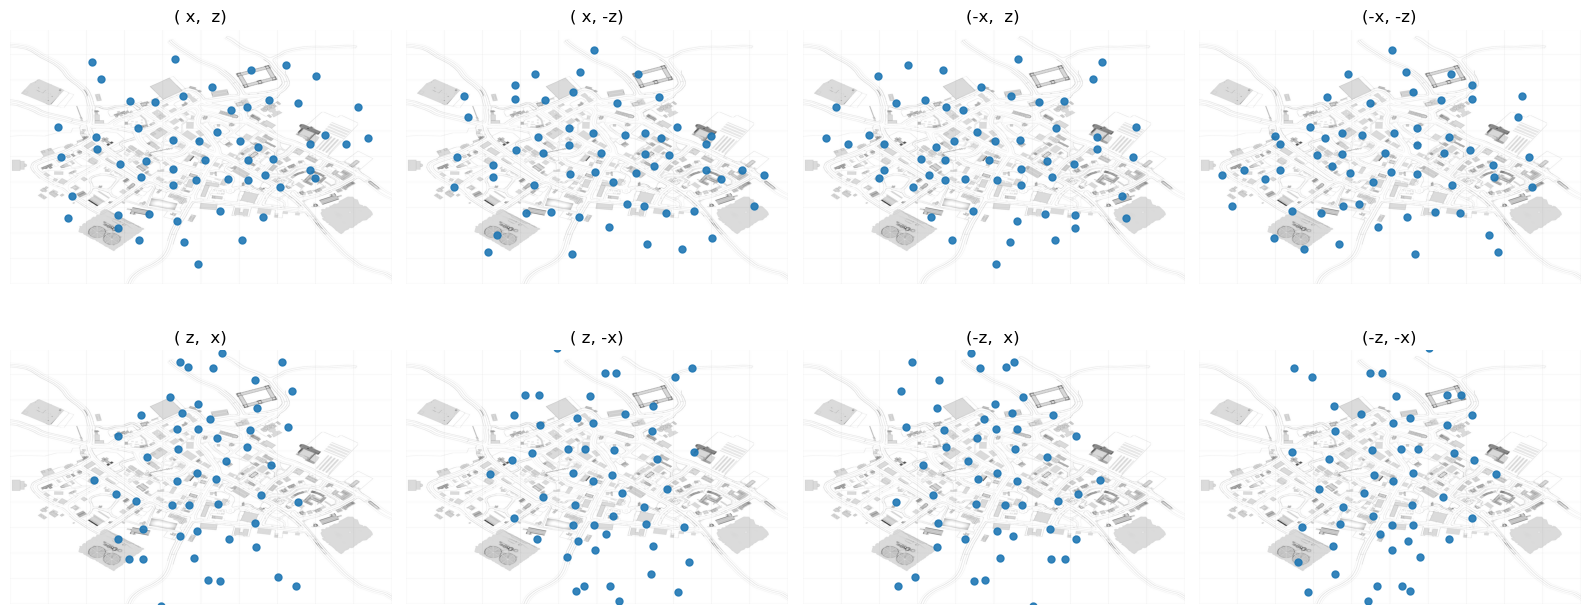

In [9]:

img = Image.open(img_path)

with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# choose which coordinate source to use:
POS_KEY = "AvatarPositionGlobal"   # try also "AvatarCenterWorld"

x = np.array([v[POS_KEY]["x"] for v in data.values()], dtype=float)
z = np.array([v[POS_KEY]["z"] for v in data.values()], dtype=float)

# use fixed bounds like your grey plot (adjust if needed)
xmin, xmax = -450, 450
zmin, zmax = -300, 300

# 8 common world→plot mappings
candidates = [
    ("( x,  z)",  x,  z),
    ("( x, -z)",  x, -z),
    ("(-x,  z)", -x,  z),
    ("(-x, -z)", -x, -z),
    ("( z,  x)",  z,  x),
    ("( z, -x)",  z, -x),
    ("(-z,  x)", -z,  x),
    ("(-z, -x)", -z, -x),
]

fig, axes = plt.subplots(2, 4, figsize=(16, 7))
axes = axes.ravel()

for ax, (label, X, Z) in zip(axes, candidates):
    ax.imshow(img, extent=[xmin, xmax, zmin, zmax], origin="lower")
    ax.scatter(X, Z, s=25, alpha=0.9)
    ax.set_title(label)
    ax.set_xlim(xmin, xmax); ax.set_ylim(zmin, zmax)
    ax.axis("off")

plt.tight_layout()
plt.show()


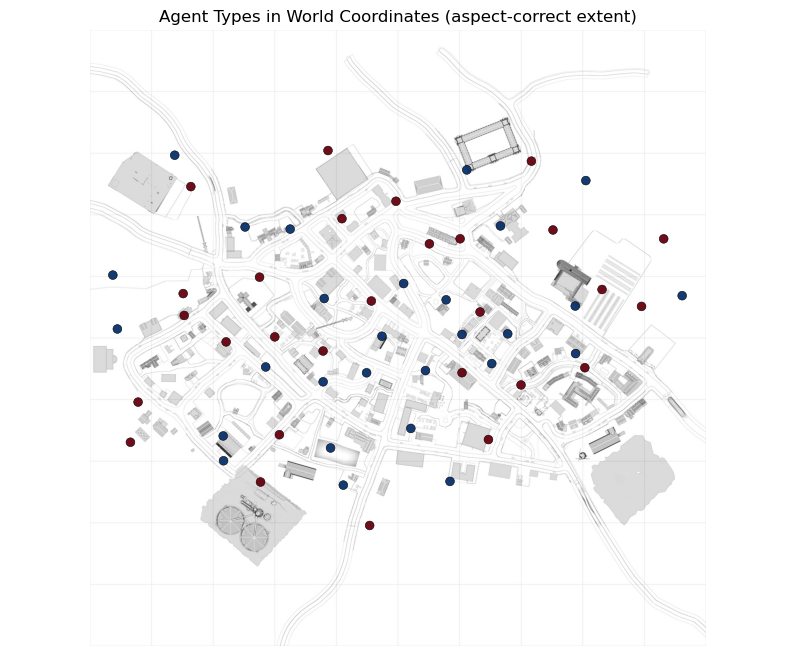

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 1) image aspect ratio
W, H = img.size
img_aspect = W / H  # width / height

# 2) agent bounds (world)
xmin0, xmax0 = df["x"].min(), df["x"].max()
zmin0, zmax0 = df["z"].min(), df["z"].max()

# center + ranges
xmid = 0.5 * (xmin0 + xmax0)
zmid = 0.5 * (zmin0 + zmax0)
xrange0 = (xmax0 - xmin0)
zrange0 = (zmax0 - zmin0)

# 3) expand ranges to match the image aspect ratio (so the map is not stretched)
# we want: (xrange / zrange) == img_aspect
xrange = xrange0
zrange = zrange0

if (xrange / zrange) < img_aspect:
    # too "tall" → expand x-range
    xrange = zrange * img_aspect
else:
    # too "wide" → expand z-range
    zrange = xrange / img_aspect

# add padding (in world units)
pad = 30
xrange += 2 * pad
zrange += 2 * pad

xmin, xmax = xmid - xrange/2, xmid + xrange/2
zmin, zmax = zmid - zrange/2, zmid + zrange/2

# 4) plot (same as yours, just with fixed extent logic)
plt.figure(figsize=(10, 8))
plt.imshow(img, extent=[xmin, xmax, zmin, zmax], origin="lower")

plt.scatter(
    df["x"], df["z"],
    c=df["color"],
    s=40, edgecolor="black", linewidth=0.4, alpha=0.95
)

plt.axis("equal")
plt.axis("off")
plt.title("Agent Types in World Coordinates (aspect-correct extent)")
plt.show()


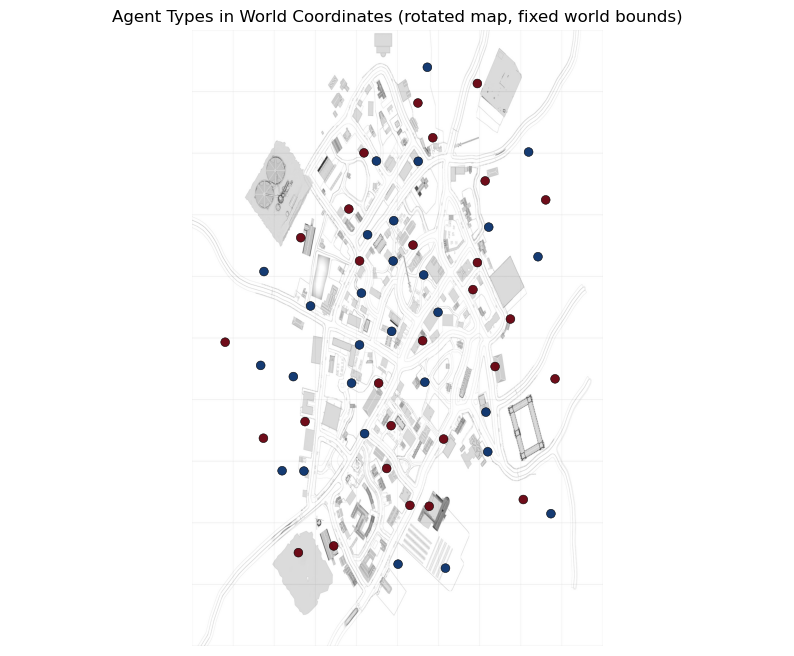

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
# world bounds of the map capture (meters) — from your correct grey plot
xmin_map, xmax_map = -450, 450
zmin_map, zmax_map = -300, 300


img_rot = img.transpose(Image.ROTATE_90)

# swap extents because the image is rotated
xmin, xmax = zmin_map, zmax_map
zmin, zmax = xmin_map, xmax_map

plt.figure(figsize=(10, 8))
plt.imshow(img_rot, extent=[xmin, xmax, zmin, zmax], origin="lower")

# swap plotted coordinates in the same way
plt.scatter(df["z"], df["x"], c=df["color"], s=40, edgecolor="black", linewidth=0.4, alpha=0.95)

plt.axis("equal"); plt.axis("off")
plt.title("Agent Types in World Coordinates (rotated map, fixed world bounds)")
plt.show()
